# Homework 4

In this homework we will practice basic analysis such as feature extraction and data transforms (Fourier, wavelet), and feature extraction.


**1. Ice-shelf seismograms** (10 points)

Time-domain filtering, 1D Fourier transform.

**2. TEC from the Hunga-Tunga explosion** (10 points)

Time-domain filtering, 1D wavelet transform.

**3. 2D Crustal model** (10 points)

practice reading netcdf, making maps and exploring 2D spectral content.



## 1) Time Frequency analysis of iceshelf vibrations 

We will explore the spectral content of the vibrations felt on iceshelves. We first download seismic data, then filter it at different frequency bandwidths, then plot the spectrogram and comment on the data.

The seismic data is handled by the Obspy package. Review the obspy tutorial that Ariane.
We will download the data presented in: Aster, R.C., Lipovsky, B.P., Cole, H.M., Bromirski, P.D., Gerstoft, P., Nyblade, A., Wiens, D.A. and Stephen, R., 2021. Swell‐Triggered Seismicity at the Near‐Front Damage Zone of the Ross Ice Shelf. Seismological Research Letters. https://doi.org/10.1785/0220200478

__Tips__:
1. Check out the SciPy filtering help here: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html. Obspy has built in functions as well, but for the sake of practicing, explore the scipy filtering functions.

2. The usual steps to handling seismic data are: data download (``get_waveforms``) & removing the instrumental response (``remove_response``).




**a. Import the relevant Obspy python modules (1 point).**

In [1]:
!pip install wget

  Using cached wget-3.2-py3-none-any.whl


In [4]:
# Import the Obspy modules that will be useful to download seismic data
import numpy as np
import obspy
import obspy.clients.fdsn.client as fdsn
from obspy import UTCDateTime
import matplotlib.pyplot as plt
import pandas as pd
import wget
import os
from scipy import signal

**b. Data download (1 point)**

We will now download the data from station "DR01" from seismic network "XH", channel "LHN" from 1/1/2015 until 3/31/2015. The client will be the "IRIS" data center. Obspy functions take on UTCDateTime formatted obspy datetime object, be sure to call or import that specific function. (1 point)

In [3]:
# answer below
network = 'XH'
station = 'DR01'
channel = 'LHN'# this channel gives a low frequency, 1Hz signal.
Tstart = UTCDateTime(2015,1,1,0,0,0)
Tend =  UTCDateTime(2015,1,15,0,0,0)# UTCDateTime(year=2022, month=10, day=8)
fdsn_client = fdsn.Client('IRIS') # client to query the IRIS DMC server

# call to download the specific data: earthquake waveforms
Z = fdsn_client.get_waveforms(network=network, station=station, location='--', channel=channel, starttime=Tstart, \
    endtime=Tend, attach_response=True)
# basic pre-processing: merge all data if there is gaps, detrend, taper,
#  remove the seismic instrumental response to go from the digitizer units to ground motion (velocity) units.
Z.merge(); 
Z.detrend(type='linear');
Z[0].taper(max_percentage=0.05);
Z[0].remove_response()


XH.DR01..LHN | 2015-01-01T00:00:00.000000Z - 2015-01-15T00:00:00.000000Z | 1.0 Hz, 1209601 samples

In [4]:
# how many days did we download?
dt=Tend-Tstart # in seconds
Ndays = int(dt/86400) # in days
print(Ndays)

14


**c. Time series filtering (2 points)**

Now we will filter the trace to explore its frequency content. We will apply 3 filters:
1. a ``lowpass`` filter to look at seismic frequencies below 0.01Hz, or 100 s period

2. a ``bandpass`` filter to look at seismic frequencies between 0.01Hz-0.1 Hz (10-100s)

3. a ``highpass`` filter to look at seismic frequencies higher than 0.1 Hz (10s) and until the time series Nyquist frequency (0.5Hz since the data is sampled at 1 Hz).

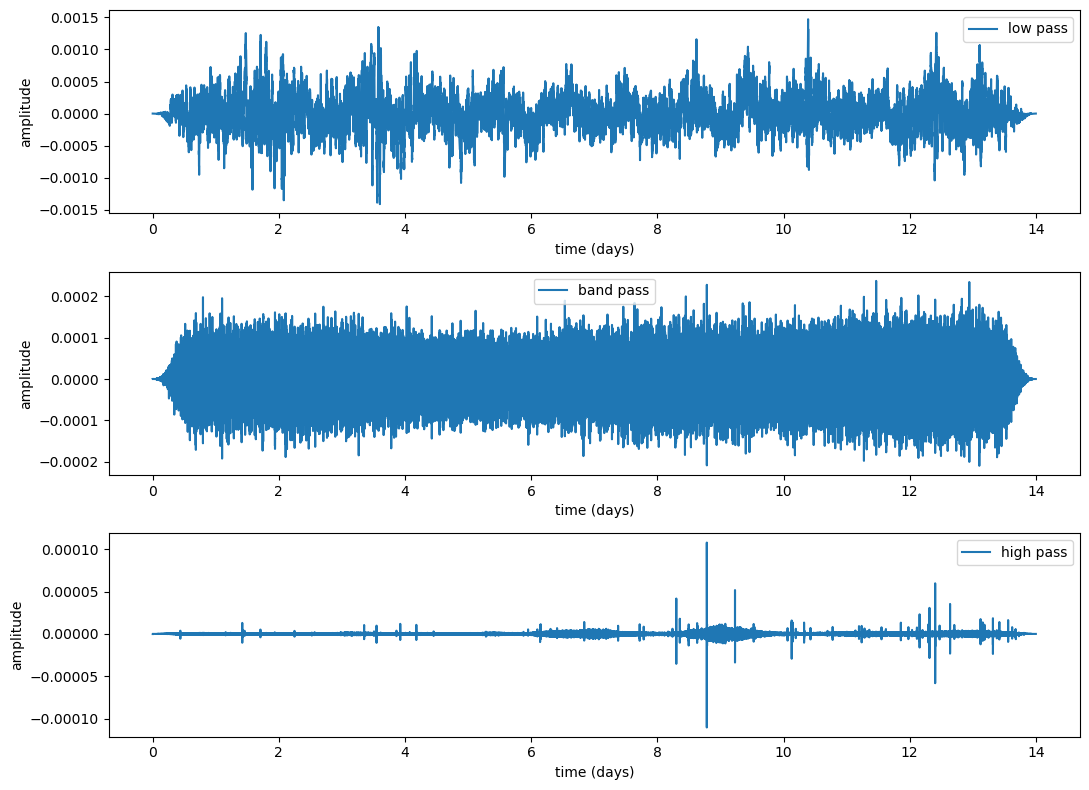

In [5]:
# answer below 
from obspy import Trace
import scipy.signal as signal
from scipy.signal import butter,buttord,  sosfiltfilt, freqs ,hann
# Here we use a Butterworth filter to select the spectral content of the waveform. 
# I like to use Buttord because it finds the order of the filter that meets the amplitude reduction criterion
# it's a lot more intuitive! https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.buttord.html
fs = Z[0].stats.sampling_rate
z=np.asarray(Z[0].data)

lsos = signal.butter(4,0.01, 'lp', fs=fs, output='sos')
bsos = signal.butter(4,[0.01,0.1], 'band', fs=fs, output='sos')
hsos = signal.butter(4,0.1, 'hp', fs=fs, output='sos')

lzf = Trace(signal.sosfilt(lsos, Z[0].data))
bzf = Trace(signal.sosfilt(bsos, Z[0].data))
hzf = Trace(signal.sosfilt(hsos, Z[0].data))

t=Z[0].times()

fig,ax=plt.subplots(3,1,figsize=(11,8))
ax[0].plot(t/86400,lzf,label='low pass')
ax[0].set_xlabel('time (days)')
ax[0].set_ylabel('amplitude')
ax[0].legend()
ax[1].plot(t/86400,bzf,label='band pass')
ax[1].set_xlabel('time (days)')
ax[1].set_ylabel('amplitude')
ax[1].legend()
ax[2].plot(t/86400,hzf,label='high pass')
ax[2].set_xlabel('time (days)')
ax[2].set_ylabel('amplitude')
ax[2].legend()
fig.tight_layout()


**c. Fourier transform (3 points)**


Perform and the Fourier amplitude spectrum of the seismogram. Don't forget to label the figure properly! Use the Fourier frequency vector for x-axis. Use the tutorials for inspirtion.

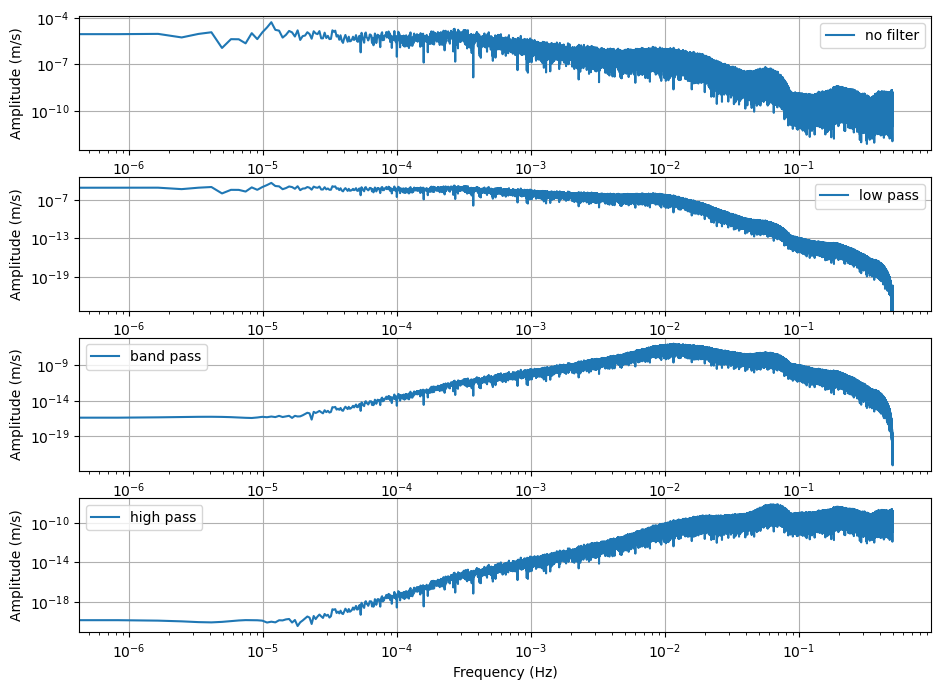

In [6]:
# import FFT modules
# answer below
from scipy.fftpack import fft, ifft, fftfreq, next_fast_len

npts = Z[0].stats.npts
## FFT the signals
# fill up until 2^N value to speed up the FFT
Nfft = next_fast_len(int(Z[0].data.shape[0])) # this will be an even number
freqVec = fftfreq(Nfft, d=Z[0].stats.delta)[:Nfft//2]

Z.taper(max_percentage=0.05)
Zhat = fft(Z[0].data,n=Nfft)#/np.sqrt(Z[0].stats.npts)
lzf.taper(max_percentage=0.05)
bzf.taper(max_percentage=0.05)
hzf.taper(max_percentage=0.05)
zlhat = fft(lzf.data,n=Nfft)#/np.sqrt(Z[0].stats.npts)
zbhat = fft(bzf.data,n=Nfft)#/np.sqrt(Z[0].stats.npts)
zhhat = fft(hzf.data,n=Nfft)#/np.sqrt(Z[0].stats.npts)


fig,ax=plt.subplots(4,1,figsize=(11,8))
ax[0].plot(freqVec,np.abs(Zhat[:Nfft//2])/Nfft,label='no filter')
ax[0].grid(True)
ax[0].set_xscale('log');ax[0].set_yscale('log')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Amplitude (m/s)')
ax[0].legend()

ax[1].plot(freqVec,np.abs(zlhat[:Nfft//2])/Nfft,label='low pass')
ax[1].grid(True)
ax[1].set_xscale('log');ax[1].set_yscale('log')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Amplitude (m/s)')
ax[1].legend()

ax[2].plot(freqVec,np.abs(zbhat[:Nfft//2])/Nfft,label='band pass')
ax[2].grid(True)
ax[2].set_xscale('log');ax[2].set_yscale('log')
ax[2].set_xlabel('Frequency (Hz)')
ax[2].set_ylabel('Amplitude (m/s)')
ax[2].legend()

ax[3].plot(freqVec,np.abs(zhhat[:Nfft//2])/Nfft,label='high pass')
ax[3].grid(True)
ax[3].set_xscale('log');ax[3].set_yscale('log')
ax[3].set_xlabel('Frequency (Hz)')
ax[3].set_ylabel('Amplitude (m/s)')
ax[3].legend()




Comment on the spectral content of the seismograms. How does the relative contribution of the low, intermediate, and high frequency signal compares with the relative amplitude observed in the bandpass filtered time series?
- In general, much of the original amplitude is suppresed after filtering (amplitudes are $10^{-5}$ before and $10^{-8}$ or $10^{-9}$ after filtering)
- We can see here that the bandpassed signal is flat between 10-100s periods. The low passed signal is flat under 100s and the high-passed signal is flat for signal between ~10s and ~1Hz
- The low passed data has the highest amplitudes at periods greater than 100s
- The high passed data have the lowest amplitudes because the original signal has the lowest amplitudes at frequencies in the 'hp' pass band

**d. Synthetic noise (3 points)**

We have now a good idea of what the amplitude of seismic waves are at this station. Now create a noise signal using the Fourier amplitude spectrum of the seismic signal, and with a random phase. You can use the notes from our first Numpy example (2.7_data_transforms.ipynb)

In [25]:

# answer below
from numpy import random
from scipy.fftpack import ifft,ifftshift 
# nvec = np.abs(random.uniform(-np.pi,np.pi,len(Zhat)))
# svec = np.abs(Zhat[:Nfft])/Nfft
# snr = 20*np.log10(np.max(svec)/np.max(nvec))

npts = Z[0].stats.npts
## FFT the signals
# fill up until 2^N value to speed up the FFT
Nfft = next_fast_len(int(Z[0].data.shape[0])) # this will be an even number
freqVec = fftfreq(Nfft, d=Z[0].stats.delta)[:Nfft//2]
Z.taper(max_percentage=0.05)
Zhat = fft(Z[0].data, n=Nfft)#/np.sqrt(Z[0].stats.npts)

amplitude = np.abs(Zhat)/Nfft
angle = random.rand(len(amplitude)) * 2 * np.pi - np.pi # mapping to [-pi, +pi]
vfft = np.cos(angle) * amplitude + np.sin(angle) * amplitude * 1j    # Euler's formula
noise = np.abs(ifft(vfft))


**e. !Sanity check! (1 point)**

Check that the Fourier amplitude spectrum of the noise is that of the original window. Overlay them on a plot 

Text(0, 0.5, 'Amplitude (m/s)')

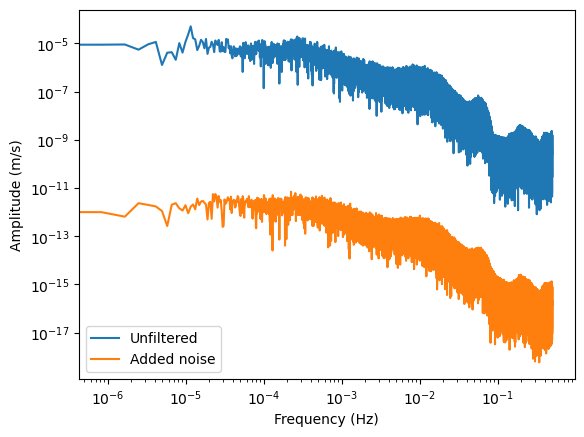

In [30]:
# answer below
plt.figure()
Nhat = fft(noise, n=Nfft)#/np.sqrt(Z[0].stats.npts)
plt.plot(freqVec, np.abs(Zhat[:Nfft//2])/Nfft, label = 'Unfiltered')
plt.plot(freqVec, np.abs(Nhat[:Nfft//2])/Nfft, label = 'Added noise')
plt.legend(loc='lower left')
# plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (m/s)')


**f. Short Time Fourier Transform (3 points)**

STFT are important transforms that are used in data science of time series. They are mainly used for denoising and for feature extraction.
Spectrograms are STFT with window overlap.

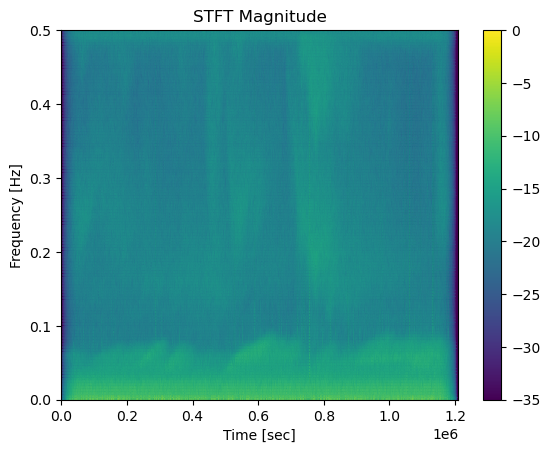

In [36]:
# answer below
from scipy.signal import stft
f, t, Zxx = stft(Z[0].data, fs = fs, noverlap = 200)
plt.pcolormesh(t, f, np.log(np.abs(Zxx)),shading='gouraud',vmin=-35,vmax=0)
plt.ylim(0,0.5)
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.show()

Now you have created a 2D image of a time series! Many seismologists use that as input to convolutional neural networks.



## 2. Time Series analysis of Hunga- Tonga
 Ghent and Crowell, 2022: TF representation of the TEC (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022GL100145). The Total Electron Content (TEC) is the total number of electrons present along a path between a radio transmitter and receiver. TEC is measured in electrons per square meter. By convention, 1 TEC Unit TECU = 10^16 electrons/m². Vertical TEC values in Earth’s ionosphere can range from a few to several hundred TECU.

 On 15 January 2022, Tonga's Hunga Tonga-Hunga Ha'apai (HTHH) volcano violently erupted, generating a tsunami that killed three people. Acoustic-gravity waves propagated by the eruption and tsunami caused global complex ionospheric disturbances. In this paper, we study the nature of these perturbations from Global Navigation Satellite System observables over the southwestern Pacific. After processing data from 818 ground stations, we detect supersonic acoustic waves, Lamb waves, and tsunamis, with filtered magnitudes between 1 and 7 Total Electron Content units.

Apply the Fourier and Wavelet transforms to the TEC time series observed a a GPS section..


### a. Read the data (1 point)

Read the CSV file file ``./TEC/ioncorr_samo_015_2022_tonga.csv``, print the keys of the data frame. THe key ``time`` is a timestamp of seconds since epoch time (1970/01/01). The data shown in the article is in the Series ``variometric_derived_TEC``. **samo** is the name of the GPS receiver. There are up to 32 satellite data saved in the CSV file.

Plot the first 2 hours of the time series

data frame keys Index(['Unnamed: 0', 'GPS_seconds', 'satellite_number',
       'variometric_derived_TEC', 'variometric_derived_TEC_filtered',
       'absolute_derived_TEC', 'absolute_derived_TEC_filtered',
       'latitude_piercing_point', 'longitude_piercing_point',
       'satellite_azimuth', 'satellite_elevation_angle',
       'distance_to_piercing_point', 'time'],
      dtype='object')


Text(0, 0.5, 'variometric_derived_TEC')

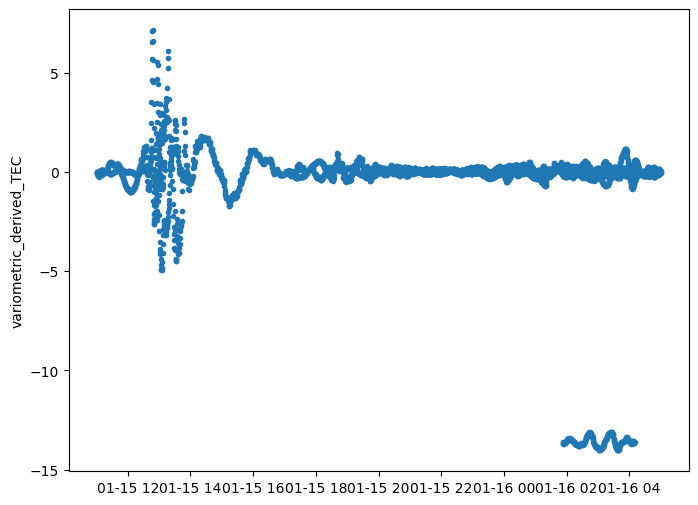

In [22]:
# answer below
import datetime
from datetime import timedelta
df = pd.read_csv('/home/jovyan/MLGeo_2022_dpsprink/Homeworks/TEC/ioncorr_samo_015_2022_tonga.csv')
print(f'data frame keys {df.keys()}')
dat = df['variometric_derived_TEC']
df['time']=np.array(df['time']).astype('datetime64[s]')
plt.figure(figsize=(8,6))
plt.plot(df['time'][:7200],dat[:7200],'.')
# plt.xlabel('2 hrs of time (seconds since 1970)')
plt.ylabel(df.keys()[3])


## b. Get station info (0.5 point)
Get the station name by splitting the string of the file name and getting the charcater after "ioncorr". You can use the python function ``split()``.

In [23]:
# answer below
fname = 'ioncorr_samo_015_2022_tonga.csv'
station = fname.split('_')[1]
print(station)

samo


## c. Plot all data (2 points)
Make a plot of all vTEC filtered (``variometric_derived_TEC_filtered``) for each satellite. Align the data with the satellite number.

Use the ``plot_date`` function from matplotlib. Convert the Series ``time`` from a ``timestamp`` to an Numpy array of dtpe ``datetime64[s]`` (time stamps are in seconds, so we need to use ``[s]``). Plot the data for each sattelite observations.

Text(0.5, 1.0, 'Globally normalized filtered TEC for each satellite')

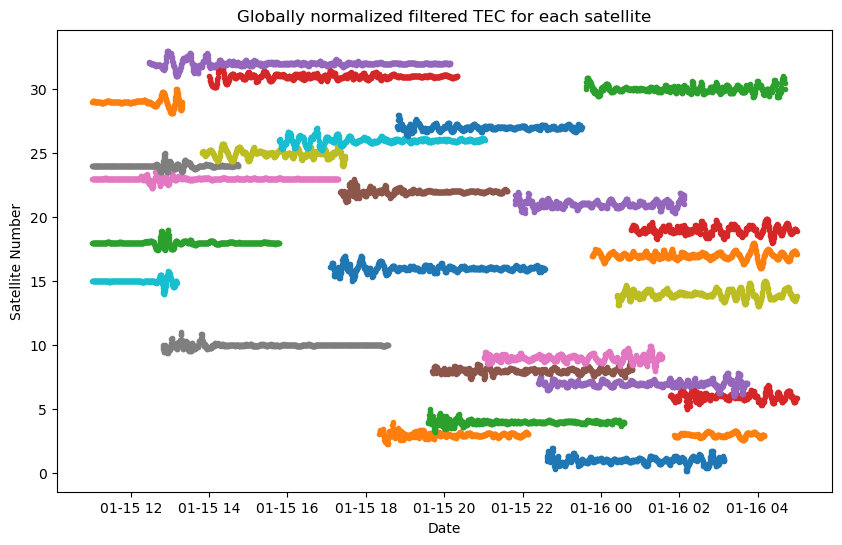

In [24]:
# answer below
fig,ax = plt.subplots(figsize=(10,6))
ii=0
for i in df['satellite_number'].unique():
    # maxdf = np.max(np.abs(df['variometric_derived_TEC_filtered']))
    maxdf = np.max(np.abs(df.loc[df['satellite_number'] == i]['variometric_derived_TEC_filtered']))
    ax.plot_date(df.loc[df['satellite_number'] == i]['time'],
             df.loc[df['satellite_number'] == i]['variometric_derived_TEC_filtered']/maxdf + i,
             '.',label=df['satellite_number'].unique()[ii])
    ii = ii + 1
plt.xlabel('Date')
plt.ylabel('Satellite Number')
plt.title('Globally normalized filtered TEC for each satellite')



You can now select one of the satellite observations that contain a full vTEC signal.

Text(0.5, 0, 'Datetime')

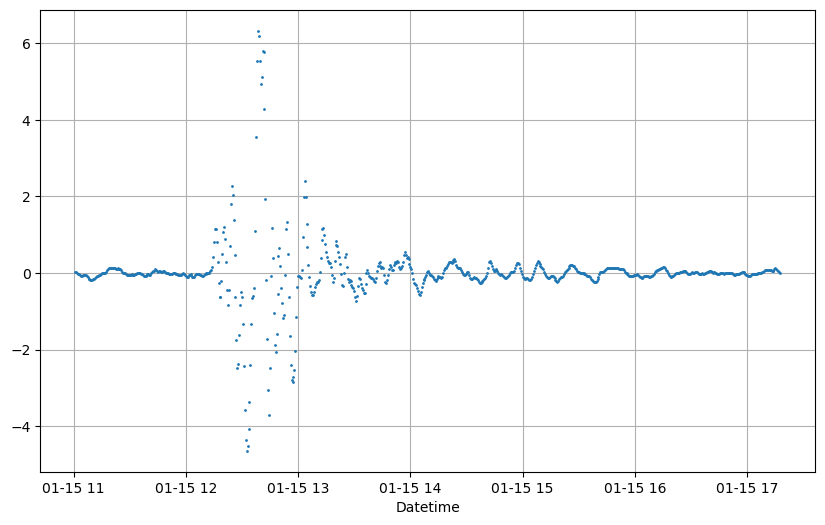

In [67]:
# here I choose No. 23 satelite
plt.figure(figsize = (10, 6))

d = df[df['satellite_number'] == 23]
plt.plot_date(d['time'], d['variometric_derived_TEC_filtered'],markersize=1)
# plt.colorbar()
plt.grid(True)
plt.xticks()
plt.xlabel("Datetime")

### d. Perform the wavelet transform (3 points)

Just like in the article, perform the wavelet transform using a Morlet transform. What can you tell about the time-frequency characteristic of these disturbances?

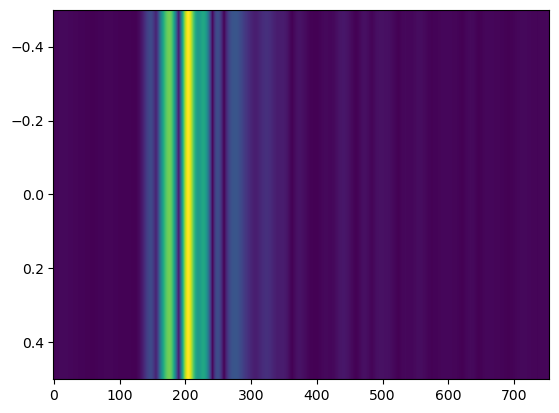

In [68]:
# # # answer below
# fs=1/30.0
# # use the number of scales
# w = 10.
# freq = np.logspace(-1, np.log10(fs/2), 100)
# widths = w*fs / (2*freq*np.pi)
# # cwtm = signal.cwt(df['variometric_derived_TEC'], signal.ricker, widths)

# # plt.imshow(cwtm, extent=[times.min(),times.max(),freq.min(),freq.max()], cmap='plasma', aspect='auto',origin='lower')


# cwtm = signal.cwt(np.array(df['variometric_derived_TEC_filtered']), signal.morlet2, widths = widths)
# plt.imshow(np.log(np.abs(cwtm)),aspect='auto')
# plt.gca().invert_yaxis()
# plt.xlabel('Time (s)')
# plt.ylabel('Period (s)')
# plt.plot(times,df['variometric_derived_TEC_filtered'])
w = 10.
fs = 1/30 # sampling frequency for the data is 1/30 Hz (30s)
cwtm = signal.cwt(np.array(d['variometric_derived_TEC_filtered']), signal.morlet2, widths = [w])
plt.imshow(abs(cwtm),aspect='auto')

Perform the wavelet transform.
Calculate the sampling frequency by taking the time difference between two samples.

In [71]:
#answer below
len(d['time'])

754

## d. Wavelet transform (3 points)
You may choose a range of wavelet scales from 1 to 50 (write this as an array of integer), and call the ``cwt`` functions using the Morlet wavelet and taking the array of scales as an input argument. Plot it with an x-axis in time (hours) and y-axis in periods.

Text(0.5, 1.0, 'Satellite 23')

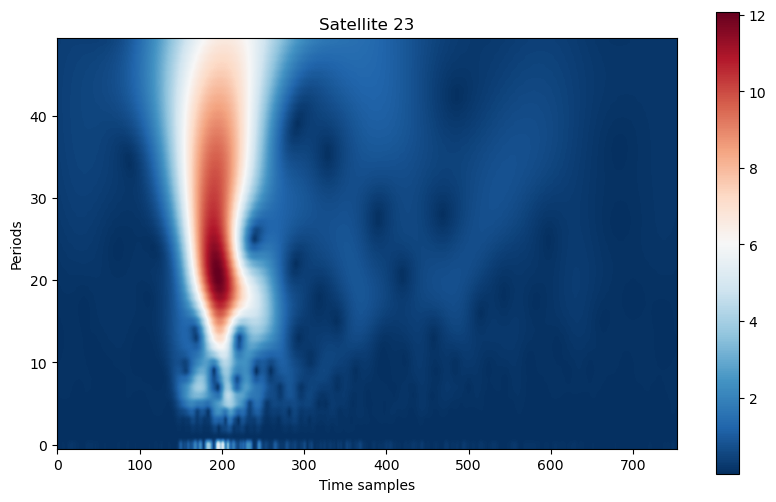

In [74]:
import scipy.signal as signal
# use the number of scales
w = np.arange(1,51)
freq = np.logspace(-1, np.log10(fs/2), 50)
widths = w*fs / (2*freq*np.pi)
cwtm = signal.cwt(np.array(d['variometric_derived_TEC_filtered']), signal.morlet2, w)
plt.figure(figsize = (10, 6))
plt.imshow(abs(cwtm), cmap = 'RdBu_r', aspect = 10)
plt.ylabel("Periods")
plt.xlabel("Time samples")
# plt.xticks(np.linspace(1, 448, 448)[::60], 
#            ["%.1f" % ((i-1642244460.000)/3600) for i in d['time']][::60])
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('Satellite 23')

## e. Interpretation (0.5 points)
Can you describe the spectral features as a function of hours since the beginning of the time series? What periods dominate when?

(answer below)
All of the energy arrives around time samples
This is likely the acoustic gravity wave Jess and Brendan identify

The authors interpret the first packet as coming from a Lamb wave (a powerful gravity-acoustic wave that travel in the lower atmosphere), the second as coming from the tsunami disturbance.

## 3) 2D Spectral analysis of geological models (10 points)

In this exercise we will correlate water table level with surface elevation. You may download the data just like in the class. The file names are ``NCM_GeologicFrameworksGrids.nc`` and ``NCM_SpatialGrid.nc``.


In the following we will prepare our data.

In [1]:
# ansert below
import netCDF4 as nc
# Download the geological framework
# file1 = wget.download("https://www.dropbox.com/s/wdb25puxh3u07dj/NCM_GeologicFrameworkGrids.nc?dl=1") #"./data/NCM_GeologicFrameworkGrids.nc"
# # Download the coordinate grids
# file2 = wget.download("https://www.dropbox.com/s/i6tv3ug15oe6yhe/NCM_SpatialGrid.nc?dl=1") #"./data/NCM_GeologicFrameworkGrids.nc"
# file3 = wget.download("https://www.dropbox.com/s/92m20pehfu7rxp2/NCM_AuxData.nc?dl=1") #"./data/NCM_AuxData.nc"

**a. Plot (2 points)**

Plot the data ``WT`` and ``elevation``. Use ``contourf``,``x`` and ``y`` as lat-long variables. You can use ``levels``  to split the color map, and ``alpha`` less than 1 to increase transparency.

In [2]:
# answer below
# read data
import os
os.chdir('/home/jovyan/MLGeo_2022_dpsprink/Homeworks')
geology = nc.Dataset("NCM_GeologicFrameworkGrids.nc")
grid = nc.Dataset("NCM_SpatialGrid.nc")
watertable = nc.Dataset("NCM_AuxData.nc")

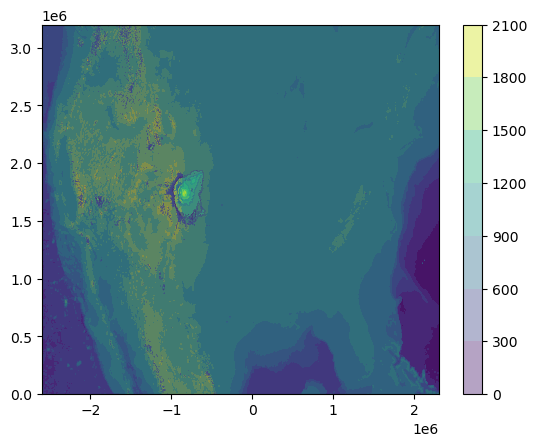

In [5]:
# plot below
# create a grid of latitude and longitude
x = grid['x'][0:4901, 0:3201]
y = grid['y'][0:4901, 0:3201]
elevation = geology['Surface Elevation'][0:4901, 0:3201]
watertabledepth = watertable['Water Table Depth'][0:4901, 0:3201]
plt.contourf(x, y, elevation, levels = 10)
d = plt.contourf(x, y, watertabledepth, levels = 6, alpha = 0.4)
plt.colorbar(d)

# recreate the lat long vectors.
minlat,maxlat = min(grid['Latitude vector'][:]),max(grid['Latitude vector'][:])
minlon,maxlon = min(grid['Longitude vector'][:]),max(grid['Longitude vector'][:])
xlat = np.linspace(minlat,maxlat,3201)
xlon = np.linspace(minlon,maxlon,4901)

**b. Perform and plot the 2D Fourier transforms (4 points)**

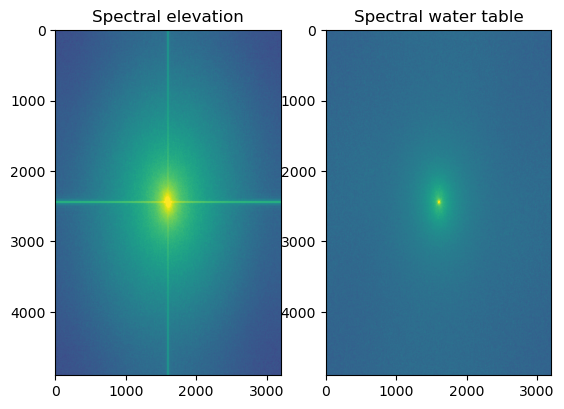

In [6]:
# answer below
from scipy.fftpack import fft2, fftfreq,fftshift,ifft2
import matplotlib.cm as cm
from obspy.geodetics import degrees2kilometers

el = fft2(elevation)
wt = fft2(watertabledepth)

plt.subplot(1, 2, 1)
plt.imshow(fftshift(np.log10(np.abs(el)/el.size)),vmin=-4, vmax=0, cmap='viridis')
plt.title('Spectral elevation')

plt.subplot(1, 2, 2)
plt.imshow(fftshift(np.log10(np.abs(wt)/wt.size)),vmin=-4, vmax=0, cmap='viridis')
plt.title('Spectral water table')


plt.show()

**c. Interpretation (1 point)**

Comment on the wavelengths that dominate the DEM and the water table wavelengths

(answer below)
small wavenumbers dominate (i.e. low f long wavelengths)

**d. 2D filtering (3 points)**

Find a way to low pass filter the image (spectral filtering or convolution)

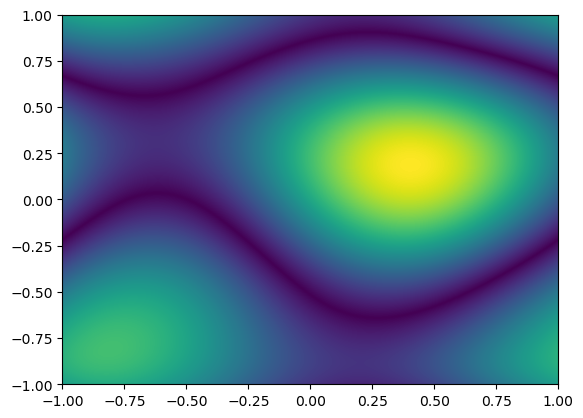

In [13]:
# solution
win1d = np.abs(np.blackman(el.shape[0]))
win2d = np.abs(np.blackman(el.shape[1]))
win = np.sqrt(np.outer(win1d,win2d)) 
fftwin = fft2(win)

filt = el*fftwin
ifilt = ifft2(filt)

plt.imshow(np.abs(ifilt),aspect='auto', cmap='viridis',extent=[-1,1,-1,1])


Now we will filter or compress by taking the largest Fourier coefficients of the image.

In [14]:
# Sort the Fourier coefficients
Zsort = np.sort(np.abs(np.abs(el).reshape(-1)))

Plot and reconstruct the image of the water table map with 1% until 10% of the data (like in class)

We are keeping up to 0.010000 the number of Fourier coefficients


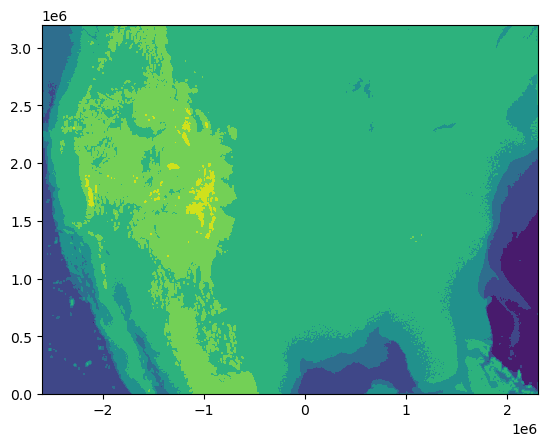

In [19]:

#snwer below
from IPython import display
import time
for keep in (0.1,0.05,0.01):
    display.clear_output(wait=True)
    thresh = Zsort[int(np.floor( (1-keep)*len(Zsort) ))]
    ind = np.abs(el)>thresh
    Atlow = el * ind # here we zero out the matrix
    # Here we count the number of non-zeros in the matrix
    print("We are keeping up to %f the number of Fourier coefficients" % keep)
    Alow = ifft2(Atlow).real
    plt.contourf(x, y, Alow)
    time.sleep(1)

Now we will compare the original 2D data set with the Fourier compressed data


We are keeping up to 0.010000 the number of Fourier coefficients


(-2600000.0, 2300000.0, 0.0, 3200000.0)

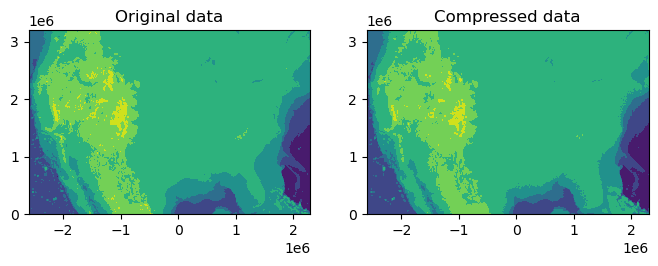

In [20]:
# answer below
keep=0.01
thresh = Zsort[int(np.floor( (1-keep)*len(Zsort) ))]
ind = np.abs(el)>thresh
Atlow = el * ind # here we zero out the matrix
# Here we count the number of non-zeros in the matrix
print("We are keeping up to %f the number of Fourier coefficients" % keep)
Alow = ifft2(Atlow).real


fig,ax=plt.subplots(1,2,figsize=(8,8),sharex=True)
ax[0].contourf(x, y, elevation);ax[0].set_title('Original data')
ax[0].axis('scaled')
ax[1].contourf(x, y, Alow);ax[1].set_title('Compressed data')
ax[1].axis('scaled')